In [1]:
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
import os
from os import path
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

cwd = os.getcwd()
cwd

import joblib

In [18]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'PRISMA' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_spots.xlsx'
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
 
data = pd.read_excel(target_file, sheet_name = 'band_mean', header = None, index_col = None) # choose sheet: 'band_mean', 'continuum', 'continuum_removed'
data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None)
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None)
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None)

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'bad_age_idx' in locals():
    del bad_age_idx
if 'bad_band_idx' in locals():
    del bad_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
bad_band_idx = np.r_[97:110,141:169,226:230] # choose bands to drop by index
bad_age_idx = np.where((pix_count == 0) | (pix_count <10))# (age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48) )# | (unit == 'Q2.5a') | (unit == 'Q2.5b')) #  choose age to drop (two decimels)
if 'bad_age_idx' in locals():
    data = data.drop(np.r_[bad_age_idx], axis=0)
    data_std = data_std.drop(np.r_[bad_age_idx], axis=0)
    age = np.delete(age, bad_age_idx)
    age_sd = np.delete(age_sd, bad_age_idx)
    age_n = np.delete(age_n, bad_age_idx)
    fan = np.delete(fan, bad_age_idx)
    unit = np.delete(unit, bad_age_idx)
    unique = np.delete(unique, bad_age_idx)
    pix_count = np.delete(pix_count, bad_age_idx)
    spots_meta = spots_meta.drop(np.r_[bad_age_idx], axis=0)
    
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('some ages dropped')
else:
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No ages dropped')
    
# drop chosen values from dataset(s)
if 'bad_band_idx' in locals():
    #data = data.drop(np.r_[bad_band_idx], axis=1)
    #nm_names = np.delete(nm_names, bad_band_idx)
    data.iloc[:,bad_band_idx] = np.nan # if bad bands chosen, set band bands as 0 for PCA` #!!change to 0 if NOT normalizign first!!!
    data_std.iloc[:,bad_band_idx] = np.nan #!!change to 0 if NOT normalizign first!!!
    
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    data_plot.iloc[:,bad_band_idx] = np.nan
    data_std_plot.iloc[:,bad_band_idx] = np.nan
    print('some bands dropped')
else:
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No bands dropped')

print(np.shape(data))

some ages dropped
some bands dropped
(20, 230)


In [19]:
# import model data
# x_data
x_dat = pd.DataFrame(data)
x_dat = x_dat.reset_index(drop=True)
x_dat = x_dat.dropna(axis='columns').reset_index(drop=True)

scaler_x = StandardScaler()
x_dat_norm = scaler_x.fit_transform(x_dat)
print(x_dat.head())

# y data
y_dat = pd.DataFrame({'age':age})
print(y_dat.head())

        0         1         2         3         4         5         6    \
0  0.095016  0.087031  0.086043  0.092358  0.097595  0.104654  0.110789   
1  0.072552  0.066371  0.066350  0.070230  0.074420  0.080428  0.086002   
2  0.092628  0.084281  0.082825  0.088585  0.095247  0.103068  0.108866   
3  0.076524  0.071851  0.070685  0.075591  0.079310  0.085356  0.090487   
4  0.077176  0.071142  0.070311  0.074786  0.078883  0.084782  0.090278   

        7         8         9    ...       216       217       218       219  \
0  0.113885  0.115541  0.120763  ...  0.223382  0.205818  0.205955  0.233426   
1  0.088019  0.089246  0.093221  ...  0.178489  0.164673  0.162031  0.184269   
2  0.111967  0.113537  0.119765  ...  0.231434  0.212615  0.216693  0.238236   
3  0.093323  0.095023  0.099331  ...  0.208660  0.193258  0.187744  0.215425   
4  0.092662  0.094946  0.099416  ...  0.206747  0.190891  0.185394  0.210658   

        220       221       222       223       224       225  
0  0

### Load data for modeled y locations

In [5]:
#log(0) # stopper for kernal reset

# Load data at all locations (i.e. andes) where exhumation (y) will be predicted using the model
# merge with exisitng x data, normalize, then seperate
# train and test model using known x,y data
# predict new x data using trained model
# un-normalize data to get physical exhumation values

In [20]:
# organize data for MLP nueral network model
xy = x_dat
xy['age'] = y_dat

xy = xy.sample(frac=1).reset_index(drop=True)
xy = xy.sample(frac=1).reset_index(drop=True) # shuffle again

x = xy.drop(labels = 'age', axis=1)
y = xy['age']

In [21]:
# SEQUENTIAL SELECTION OF TRAIN/TEST & STANDARDIZED

fracTrain = 0.8 #fraction of data to use for training
ntrain = int(len(y)*fracTrain)

x_train = x[:ntrain] #train on n observations
y_train = y[:ntrain]

x_test = x[ntrain:] #test on remaining observations
y_test = y[ntrain:]

print(np.shape(x_train))
print(np.shape(x_test))

(16, 185)
(4, 185)


In [12]:
# kernal restart stopper
#log(0)

#This chunk of code is relatively flexible and can be used to loop through a range of parameters
# iterate through model combinations and store those with 'best' RMSE
# Each model run will start with randomn initialization parameters, and then learn to optimize. 

# Try combinations e.g., 
#MLP using 1 hidden layer with 10 neurons
#MLP using 1 hidden layer with 1-10 neurons

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 11 #maximum number of hidden neurons to loop through
max_hidden_layers = 8 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.001
momentum = 0.7
max_iter = 3000 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.20 #fraction of training data to use as validation
alpha = 0.01
#####

y_out_all_nhn = []
y_out_ensemble = [] #store predicted y values from each model in final ensemble
RMSE_ensemble = [] #RMSE for each model in the ensemble
nhn_best = []
nhl_best = []
model_best = [] # store lsit of best model in each run (lowest RMSE)

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    model_store = []
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init,
                                 momentum = momentum,
                                alpha = alpha)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
            model_store.append(model)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    model_best.append(model_store[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_test, y_out_ensemble_mean)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 8 hidden layers, 3 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 8
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 BEST: 6 hidden layers, 7 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 8
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

	 BEST: 6 hidden layers, 8 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

	 # Hidden Layers = 4
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 6
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 7
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 6 hidden layers, 2 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 8
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 BEST: 7 hidden layers, 1 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 5
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 5 hidden layers, 5 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 8
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

	 BEST: 8 hidden layers, 4 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 3
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 4
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 5
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7
		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 6 hidden layers, 5 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 3
		 # hidden neurons = 1
		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 4
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11
	 # Hidden Layers = 5
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 4
		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 6
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 2
		 # hidden neurons = 3


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `b

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 # Hidden Layers = 7
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8
		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 11
	 # Hidden Layers = 8
		 # hidden neurons = 1


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 5


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 6
		 # hidden neurons = 7


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 8


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 9


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


		 # hidden neurons = 10
		 # hidden neurons = 11


C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
C:\Anaconda\envs\env_eosc510\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:542: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


	 BEST: 4 hidden layers, 1 hidden neurons


In [13]:
# Extract 'best' model of each model run, and store as a list of models
# this wil be run as an ensemble

y_pred_best = []
RMSE_best = []

for i in range (len(model_best)):
    y_pred = model_best[i].predict(x_test)
    RMSE_best.append(rmse(y_test,y_pred))
    y_pred_best.append(y_pred)

y_pred_ensemble = np.mean(y_pred_best,axis=0)
RMSE_best_ensemble = rmse(y_test, y_out_ensemble_mean)

print(y_pred_ensemble)
print(RMSE_best_ensemble)

[36.56101189 33.44208933 35.63981972 33.30130091]
42.52668953740312


C:\Users\htccr\AppData\Local\Temp/ipykernel_20760/239109608.py:35: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('Testing Data (Observation n)', Size = 12)


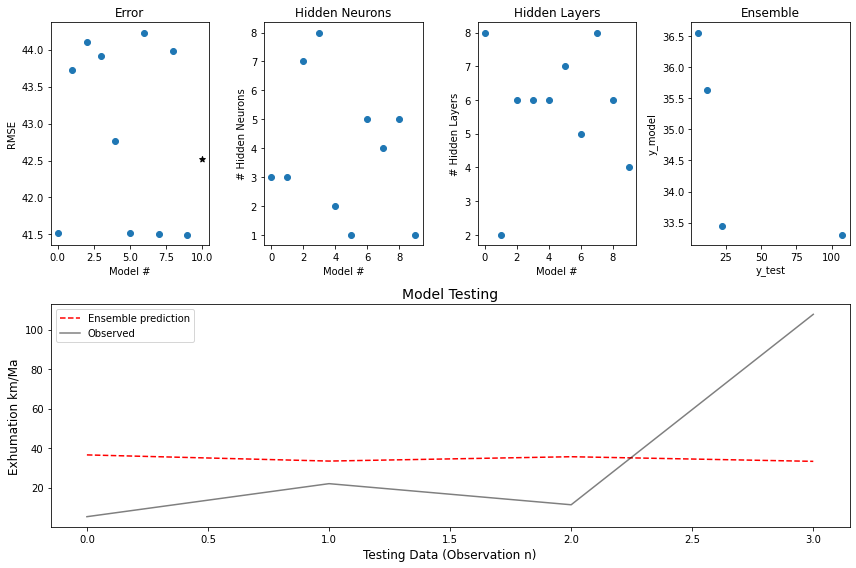

In [14]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean, color = 'red', label = 'Ensemble prediction', linestyle = '--')
plt.plot(np.array(y_test),alpha = 0.5, color = 'black', label = 'Observed', linestyle = '-')
plt.title('Model Testing', size = 14)
plt.xlabel('Testing Data (Observation n)', Size = 12)
plt.ylabel('Exhumation km/Ma', size = 12)
plt.legend()
plt.xlim()

plt.tight_layout()

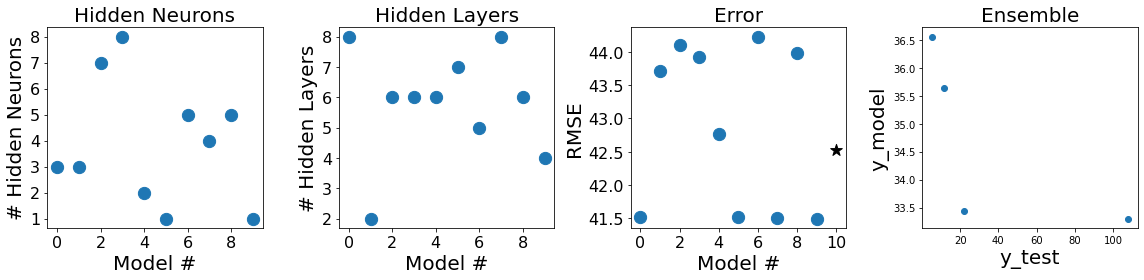

In [15]:
#visualize performance metrics/etc

saveIt = 0

plt.figure(figsize=(16,4))

plt.subplot(141)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(142)
plt.scatter(range(len(nhl_best)),nhl_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.subplot(143)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.subplot(144)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test', fontsize = 20)
plt.ylabel('y_model', fontsize = 20)
plt.title('Ensemble', fontsize = 20)

plt.tight_layout()

if saveIt:
    plt.savefig('model_diagnostics.png')
    
plt.show()

Text(0.5, 1.0, 'Error')

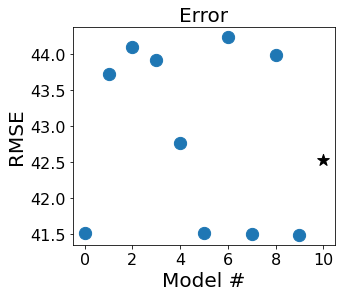

In [16]:
# plot just RMSE 
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

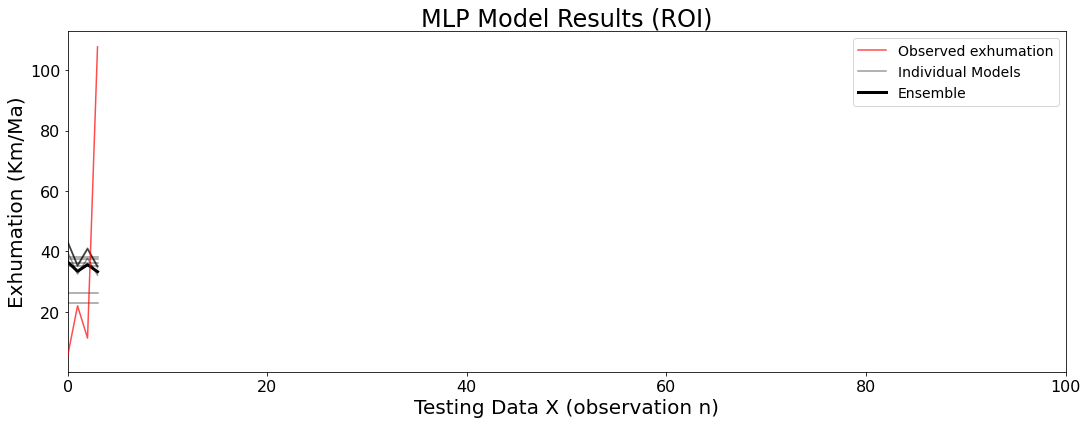

In [17]:
#visualize individual model runs

saveIt = 0

plt.figure(figsize = (15,6))

plt.plot(range(len(y_test)),y_test,label='Observed exhumation',zorder = 3, color = 'red', alpha = 0.7)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4, zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3) # plot ensemble

plt.title('MLP Variables; sorted', size = 24)
plt.xlabel('Testing Data X (observation n)', size = 20)
plt.ylabel('Exhumation (Km/Ma)', size = 20)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results (ROI)', fontsize = 24)
plt.legend(fontsize = 14, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('model_results.png')
plt.xlim(0,100)
plt.show()

### STOP, save and/or load models, will overwrite existing!!

In [ ]:
#log(0) # stop kernal reset

# save model(s)
for i in range (len(model_best)):
    filename = 'saved_models/model_best_andes_nonorm{}.sav'.format(i)
    joblib.dump(model_best[i], filename)


In [ ]:
log(0) # stop kernal reset

# load the model from disk
model_loaded = []

for i in range (len(model_best)):
    filename = 'saved_models/model_best_andes{}.sav'.format(i)
    store_model = joblib.load(filename)
    model_loaded.append(store_model)

# Use the following to run model now
# imported_models[i].predict(x_new)

In [ ]:
run_model = model_best[].predict(x_new)

### predict NEW data

In [ ]:
log(0) # stop for kernal reset, only run if new model!

## IMPORT NEW X DATA, PREDICT Y, EXPORT .CSV ##

# import new data 
x_new = x_new_norm # choose x data, in same order as model

# run model ensemble against new x data
y_pred_ensemble = []

for i in range (len(model_best)):
    y_pred_new = model_best[i].predict(x_new)
    y_pred_ensemble.append(y_pred_new)

y_pred_ensemble_mean = np.mean(y_pred_ensemble,axis=0) # predicted y values from ensemble

# convert to physical units i.e. un-normalize 
y_pred_ensemble_mean = y_pred_ensemble_mean.reshape(1,-1)
exhumation_phys = y_pred_ensemble_mean[0]
exhumation_phys[exhumation_phys<0] = 0

# export precited data and varibales as csv
# load x_new (non-normalized)
target_file = 'data/final_dataset/x_new_andes1.csv'
x_new_orig = pd.read_csv(target_file, header = 0) 
x_new_orig = x_new_orig.dropna().reset_index(drop=True) #drop any row with an nan.

# create dataframe of predicted y, and given x variables (non-normalized)
y_pred_andes = pd.DataFrame({'X':lon_new, 
                             'Y':lat_new, 
                             'exhumation': exhumation_phys, # predicted exuamtion rates
                             'precip':x_new_og['precip'],
                            'QSS_den':x_new_og['QSS_den'],
                            'QSS_tyr':x_new_og['QSS_tyr'],
                            'geo':x_new_og['geo']})

# export data
y_pred_andes.to_csv(r'data/final_dataset/y_pred_andes_nonorm.csv', index = False)
y_pred_andes.head()

## SAVE ## inverse normalizations...
#exhumation_phys = scaler.inverse_transform(exhumation_phys)
#exhumation_phys = np.exp(exhumation_phys)
#exhumation_phys = (y_pred_ensemble_mean * ((exhumation.max()-exhumation.min()))) + exhumation.min()
#exhumation_phys = y_pred_ensemble_mean + exhumation_norm.min()
#exhumation_phys = (exhumation_phys*exhumation.std()) + exhumation.mean()
#exhumation_phys = exhumation_phys - exhumation_phys.min()

In [ ]:
# read in modeled data with predictor variables (from saved model)
target_file = 'data/final_dataset/y_pred_andes_nonorm.csv'
y_pred_andes = pd.read_csv(target_file, header = 0)
y_pred_andes

In [ ]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data

saveIt = 0

plt.figure(figsize = (15,6))
plt.scatter(y_pred_andes['Y'], y_pred_andes['exhumation'],label='Ensemble Predictions', c =  y_pred_andes['precip'], cmap = 'viridis', alpha = 0.5)

plt.xlabel('Latitude (degrees)', fontsize = 20)
plt.ylabel('km/Ma', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Modeled Exhumation', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('model_predictions.png')

plt.show()

In [ ]:
# plot predictions spatially
plt.figure(figsize = (15,10))

plt.subplot(131)
plt.scatter(x_dat['X'],x_dat['Y'], c = x_dat['exhumation'], cmap = 'hot', vmax = 1.2)
#plt.scatter(lon_modeled,lat_modeled, c = exhumation, cmap = 'hot')
plt.colorbar()
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Exhumation: Raw')

plt.subplot(132)
plt.scatter(lon_modeled,lat_modeled, c = exhumation, cmap = 'hot')
plt.colorbar()
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Exhumation: MLP Model Input')


plt.subplot(133)
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'], cmap = 'hot')
#plt.scatter(x_dat['X'],x_dat['Y'], c = 'red', vmax = 2)
plt.colorbar(label = 'mm/yr')
plt.xlim(-72,-61)
plt.ylim(-37,-18)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Modeled Exhumation')


In [ ]:
plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'], cmap = 'inferno')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Modeled Exhumation')
plt.colorbar(label = 'km/Ma')

line_list = [2,-15, -28, -33.3] # flat-slab zones, norhten, central, and Andes

for i in line_list:
    plt.axhline(y=i, color='r', linestyle='-')

In [ ]:
# by 1 degree lat
# lon width wont work sice the trange bends

lat_start = np.arange(10, -49, -1).tolist()
lat_end = np.arange(9, -50, -1).tolist()

lon_width = []
avg_ex = []
avg_precip = []
avg_den = []
avg_tyr = []

for i, j in zip(lat_start, lat_end):
    arr_min = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].min()
    arr_max = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].max()
    width = arr_max - arr_min
    
    ex_mean = y_pred_andes['exhumation'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    precip_mean = y_pred_andes['precip'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    den_mean = y_pred_andes['QSS_den'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    tyr_mean = y_pred_andes['QSS_tyr'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    
    lon_width.append(width)
    avg_ex.append(ex_mean)
    avg_precip.append(precip_mean)
    avg_den.append(den_mean)
    avg_tyr.append(tyr_mean)

lon_width_km = np.array(lon_width)*113.3
den_km_ma = np.array(avg_den) * 0.000001 # to km/ ka
den_km_ma = den_km_ma * 1000 # to km/Ma

ex_over_den = np.array(avg_ex)/np.array(den_km_ma) # av_den
ex_min_den = np.array(avg_ex) - np.array(den_km_ma)

width = pd.DataFrame({'width':lon_width,
                      'width_km': lon_width_km, #convert from degrees to km
                         'avg_ex':avg_ex,
                        'avg_precip': avg_precip,
                        'avg_den': avg_den,
                      'avg_tyr': avg_tyr,
                      'ex_over_den':ex_over_den,
                     'ex_min_den': ex_min_den})
#width = width.sort_values(by=['avg_ex']).reset_index(drop = True)

In [ ]:
#width = width.sort_values(by=['width']).reset_index(drop = True)
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.bar(lat_start,width['avg_ex'], color = 'red')
plt.ylabel('km/Ma', size = 12)
plt.title('Exhumation', size = 14)


plt.subplot(142)
plt.bar(lat_start,width['avg_precip'], color = 'lightblue')
plt.ylabel('mm/yr', size = 12)
plt.title('Precipitation', size = 14)

plt.subplot(143)
plt.bar(lat_start,width['avg_den'], color = 'brown')
plt.ylabel('mm/ky', size = 12)
plt.title('Deunudation', size = 14)

plt.subplot(144)
plt.bar(lat_start,width['avg_tyr'], color = 'darkblue')
plt.ylabel('tons/yr', size = 12)
plt.title('Suspended Sediment', size = 14)

plt.tight_layout()

In [ ]:
# explore relative relations
test =  y_pred_andes['exhumation']/y_pred_andes['QSS_den']

plt.figure(figsize = (8,5))
plt.scatter(lat_new, test, c = y_pred_andes['precip']<400, cmap = 'PiYG', alpha = 0.5, label = 'Precip > 400 mm/yr')
plt.xlabel('Latitude', size = 12)
plt.ylabel('Ratio', size = 12)
plt.title('Exumation/Precipitation', size = 14)
plt.legend()

for i in line_list:
    plt.axvline(x=i, color='r', linestyle='-')
plt.xlim()

In [ ]:
# DONT PLOT AGAINST EXISTING Y DATA
#visualize individual model runs for predicted data

saveIt = 0

plt.figure(figsize = (5,4))
#plt.scatter(y_pred_andes['Y'], y_pred_andes['exhumation'],label='Ensemble Predictions', c =  y_pred_andes['precip'], cmap = 'viridis', alpha = 0.5)
plt.scatter(y_pred_andes['precip'], y_pred_andes['QSS_den'],label='Ensemble Predictions', alpha = 0.5)


plt.xlabel('Mean Precipitation (mm/yr)', fontsize = 12)
plt.ylabel('Denudation  (mm/ky)', fontsize = 12)
plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)
#plt.title('', fontsize = 24)
#plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('model_predictions.png')

plt.show()

In [ ]:
# plot exhumation by width of range

from sklearn.linear_model import LinearRegression
import scipy
from scipy import stats

avg_ex = np.array(avg_ex).reshape(-1,1)
lon_width = np.array(lon_width).reshape(-1,1)

model_lm = LinearRegression().fit(avg_ex,lon_width_km)
r_sq = model_lm.score(avg_ex,lon_width_km)
print('coefficient of determination:', r_sq)

y_pred_lm = model_lm.predict(avg_ex)

plt.figure(figsize = (8,5))
#plt.scatter(avg_ex, lon_width_km, c =  'darkblue')
plt.scatter(width['avg_ex'], width['width_km'], c = width['ex_over_den'])
#plt.plot(avg_ex, y_pred_lm, c = 'red', linestyle = '--', alpha = 0.3)
#plt.plot(X_unpacked, Y_pred_unpacked, color='red')
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Predicted exhumation (km/Ma)', size = 12)
#plt.title('Relations to Critical Wedge ($r^2$ = {})'.format(round(r_sq,2)), size = 14)
plt.colorbar(label = 'exumation/denundation', format='%.0e')

In [ ]:
# exumation over denundation
den_km_ma_all = np.array(y_pred_andes['QSS_den']) * 0.000001 # to km/ ka
den_km_ma_all = den_km_ma_all * 1000 # to km/Ma

plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'] / den_km_ma_all, cmap = 'cividis', vmax = 2e5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Verticle Growth Proxy')
plt.colorbar(label = 'Exumation/Denundation', format='%.0e')

line_list = [2,-15, -28, -33.3] # flat-slab zones, norhten, central, and Andes

for i in line_list:
    plt.axhline(y=i, color='r', linestyle='-')

In [ ]:
# Fit Power law or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width = width.sort_values(by=['ex_over_den']).reset_index(drop = True)

X_start = np.array(width_copy['ex_over_den']).reshape(-1,1)
X = X_start
Y_start = np.array(np.array(width_copy['width_km']).reshape(-1,1))
Y = Y_start

#X = np.array(width_copy['ex_over_den']).reshape(-1,1)
#Y = np.array(np.array(width_copy['width_km']).reshape(-1,1))

# run linear regression
model_lm = LinearRegression().fit(X,Y)
Y_pred_lm = model_lm.predict(X)
r2_lm = model_lm.score(X,Y)

# take natural log
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = (np.exp(X))

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))

In [ ]:
# LOOKS LIKE A POWER LAW THAT TAPERS OFF, CHECK EARLY DATA ONLY
# Fit Power law or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width_copy = width.sort_values(by=['ex_over_den']).reset_index(drop = True)
X_start = np.array(width_copy['ex_over_den'][width_copy['ex_over_den'] <2.5]).reshape(-1,1)
X = X_start

Y_start = np.array(np.array(width_copy['width_km'][width_copy['ex_over_den'] <2.5]).reshape(-1,1))
Y = Y_start

#X = np.array(width_copy['ex_over_den']).reshape(-1,1)
#Y = np.array(np.array(width_copy['width_km']).reshape(-1,1))

# run linear regression
model_lm = LinearRegression().fit(X,Y)
Y_pred_lm = model_lm.predict(X)
r2_lm = model_lm.score(X,Y)

# take natural log
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = (np.exp(X))

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Exhumation/Denudation')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))


In [ ]:
precip_plot = np.array(np.array(width_copy['avg_precip'][width_copy['ex_over_den'] <2.5]).reshape(-1,1))

# plot regresson nice
plt.figure(figsize = (15,5))
plt.scatter(X_start, Y_start, c = precip_plot, cmap = 'BrBG', edgecolors='gray')
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--', alpha = 0.5)
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Exumation/Denundation', size = 12)
plt.title('Exumation / Denundation ($r^2$ = {})'.format(r2), size = 14)
plt.colorbar(label = 'Precipitation (mm/yr)')

### Exumation - Denudation ?
#### all units in km/ ma

In [ ]:
# exumation over denundation
den_km_ma_all = np.array(y_pred_andes['QSS_den']) * 0.000001 # to km/ ka
den_km_ma_all = den_km_ma_all * 1000 # to km/Ma

plt.figure(figsize = (5,10))
plt.grid()
plt.scatter(y_pred_andes['X'], y_pred_andes['Y'], c = y_pred_andes['exhumation'] - den_km_ma_all, cmap = 'seismic', vmin = -2, vmax = 2) # limit range so 0 is white
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Absolute Change')
plt.colorbar(label = 'km/Ma')

line_list = [2,-15, -28, -33.3] # flat-slab zones, norhten, central, and Andes

for i in line_list:
    plt.axhline(y=i, color='r', linestyle='-')

In [ ]:
# Fit Power law function or linear model
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
width_copy = width
width_copy = width.sort_values(by=['ex_min_den']).reset_index(drop = True)

X_start = np.array(width_copy['ex_min_den']).reshape(-1,1)
X = X_start

Y_start = np.array(np.array(width_copy['width_km']).reshape(-1,1))
Y = Y_start


# run linear regression
model_lm = LinearRegression().fit(X_start,Y_start)
Y_pred_lm = model_lm.predict(X_start)
r2_lm = model_lm.score(X_start,Y_start)

# take natural log
X = (X - X.min()) + 1
X = np.log(X) 
Y = np.log(Y)

# run linear regression on log data 
X = X.reshape(-1,1) # values converts it into a numpy array
Y = Y.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=True)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_unpacked = (np.exp(Y))
X_unpacked = ((np.exp(X)) -1)  + X_start.min()

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X_start, Y_start)
plt.plot(X_start, Y_pred_lm, color='red')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('Linear Model (R^2: {})'.format(round(r2_lm,2)))

plt.subplot(1,3,2)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('lm log space (R^2: {})'.format(r2))

plt.subplot(1,3,3)
plt.scatter(X_unpacked, Y_start)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.xlabel('Verticle Change (km)')
plt.ylabel('Width (km)')
plt.title('Power law, linear space ($r^2:$ {})'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))
print('Power funtion: y = {}x^{}'.format(A_pl,B))


In [ ]:
precip_plot = np.array(np.array(width_copy['avg_precip'][width_copy['ex_min_den'] <2.5]).reshape(-1,1))

# plot regresson nice
plt.figure(figsize = (15,5))
plt.scatter(X_start, Y_start, c = precip_plot, cmap = 'BrBG', edgecolors='gray')
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--', alpha = 0.5)
plt.ylabel('Width (km)', size = 12)
plt.xlabel('Verticle Change', size = 12)
plt.title('Exumation - Denundation ($r^2$ = {})'.format(r2), size = 14)
plt.colorbar(label = 'Precipitation (mm/yr)')

In [ ]:
# by geogrpahic unit
# Northern Andes, Flat Slab 1, Central Andes, Flat Slab 2, SOuthern Andes
# lon width wont work sice the trange bends

lat_start = [10,2,-15,-28,-33.3]
lat_end = [2,-15,-28,-33.3,-50]

#lon_width = []
avg_ex = []
avg_precip = []
avg_den = []
avg_tyr = []

for i, j in zip(lat_start, lat_end):
    #arr_min = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].min()
    #arr_max = y_pred_andes['X'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].max()
    width = arr_max - arr_min
    
    ex_mean = y_pred_andes['exhumation'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    precip_mean = y_pred_andes['precip'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    den_mean = y_pred_andes['QSS_den'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    tyr_mean = y_pred_andes['QSS_tyr'][(y_pred_andes['Y'] < i) & (y_pred_andes['Y'] > j)].mean()
    
    #lon_width.append(width)
    avg_ex.append(ex_mean)
    avg_precip.append(precip_mean)
    avg_den.append(den_mean)
    avg_tyr.append(tyr_mean)

In [ ]:
width = pd.DataFrame({ 'avg_ex':avg_ex,
                        'avg_precip': avg_precip,
                        'avg_den': avg_den,
                      'avg_tyr': avg_tyr,
                      'geog':['N','FS1','CA','FS2','SA']})

#width = width.sort_values(by=['width']).reset_index(drop = True)
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.bar(width['geog'],width['avg_ex'], color = 'red')
plt.ylabel('km/Ma', size = 12)
plt.title('Exhumation', size = 14)

plt.subplot(142)
plt.bar(width['geog'],width['avg_precip'], color = 'lightblue')
plt.ylabel('mm/yr', size = 12)
plt.title('Precipitation', size = 14)

plt.subplot(143)
plt.bar(width['geog'],width['avg_den'], color = 'brown')
plt.ylabel('mm/ky', size = 12)
plt.title('Deunudation', size = 14)

plt.subplot(144)
plt.bar(width['geog'],width['avg_tyr'], color = 'darkblue')
plt.ylabel('tons/yr', size = 12)
plt.title('Suspended Sediment', size = 14)

plt.tight_layout()